In [1]:
from typing import List, Tuple, Dict, Any, Optional, Callable

import numpy as np
import pandas as pd
import pyspark
import pyspark.sql.functions as F
import os
import random

from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StructField, StructType, StringType
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LogisticRegression
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
spark = SparkSession.builder\
.config("spark.driver.memory", "6g")\
.appName("diabetes_indicators").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/12 16:15:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [17]:
df = spark.read.csv("./data/diabetes/final_diabetes_dataset.csv", header=True, inferSchema=True, sep=",")
df.show(5)

+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|DIABETE3|CHCKIDNY|_RFHYPE5|TOLDHI2| _BMI5|SMOKE100|CVDSTRK3|_MICHD|_TOTINDA|_FRTLT1|_VEGLT1|_RFDRHV5|MEDCOST|GENHLTH|PHYSHLTH|MENTHLTH|SEX|_AGEG5YR|_MRACE1|EDUCA|INCOME2|
+--------+--------+--------+-------+------+--------+--------+------+--------+-------+-------+--------+-------+-------+--------+--------+---+--------+-------+-----+-------+
|       0|       0|       1|      1|2522.0|       1|       0|     0|       1|      1|      1|       0|      0|    2.0|     2.0|    88.0|  0|    10.0|    1.0|  6.0|    8.0|
|       0|       0|       0|      0|2407.0|       0|       0|     0|       0|      0|      1|       0|      0|    2.0|    88.0|    88.0|  0|     8.0|    1.0|  4.0|    3.0|
|       2|       0|       0|      0|2468.0|       1|       0|     0|       1|      1|      1|       0|      0|    3.0|    88.0|    88.0|  0|

In [30]:
def transform_data(df: pyspark.sql.DataFrame, map_dict: dict, colName: str) -> pyspark.sql.DataFrame:
    """ Function to transform predictor variable based on map_dict """
    map_col = F.create_map([F.lit(x) for i in map_dict.items() for x in i])
    new_df = df.withColumn(colName, map_col[F.col(colName)])
    
    return new_df

In [31]:
df = df.withColumn("PHYSHLTH", F.when(df["PHYSHLTH"] == 88, 0).otherwise(df["PHYSHLTH"]))
df = df.withColumn("MENTHLTH", F.when(df["MENTHLTH"] == 88, 0).otherwise(df["MENTHLTH"]))

df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 14))}, "_AGEG5YR")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 8))}, "_MRACE1")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 7))}, "EDUCA")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 9))}, "INCOME2")
df = transform_data(df, {v:idx for idx, v in enumerate(range(1, 6))}, "GENHLTH")

In [32]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "CHCKIDNY").show()

+-----------------+------+----+
|DIABETE3_CHCKIDNY|     0|   1|
+-----------------+------+----+
|                1|  4631| 222|
|                0|217175|6019|
|                2| 33184|3711|
+-----------------+------+----+



In [33]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_RFHYPE5").show()

+-----------------+------+-----+
|DIABETE3__RFHYPE5|     0|    1|
+-----------------+------+-----+
|                1|  1796| 3057|
|                0|140399|82795|
|                2|  9090|27805|
+-----------------+------+-----+



In [34]:
df.na.drop(subset=["DIABETE3", "TOLDHI2"]).crosstab("DIABETE3", "TOLDHI2").show()

+----------------+------+-----+
|DIABETE3_TOLDHI2|     0|    1|
+----------------+------+-----+
|               1|  1833| 3020|
|               0|139202|83992|
|               2| 12214|24681|
+----------------+------+-----+



In [35]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_MRACE1").show()

+----------------+------+-----+----+----+---+----+----+
|DIABETE3__MRACE1|     0|    1|   2|   3|  4|   5|   6|
+----------------+------+-----+----+----+---+----+----+
|               1|  3769|  470| 136| 172| 30| 120| 156|
|               2| 29216| 4380| 918| 616|157| 755| 853|
|               0|192056|14961|3030|4634|761|3506|4246|
+----------------+------+-----+----+----+---+----+----+



In [36]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_AGEG5YR").show()

+-----------------+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|DIABETE3__AGEG5YR|   0|   1|   10|   11|   12|    2|    3|    4|    5|    6|    7|    8|    9|
+-----------------+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|                1|  26|  57|  631|  458|  470|   75|  143|  165|  319|  449|  575|  753|  732|
|                2|  89| 147| 5355| 3529| 3343|  340|  655| 1099| 1829| 3211| 4450| 6006| 6842|
|                0|5965|7887|18443|12567|14296|11526|13807|15526|18509|23668|27129|27994|25877|
+-----------------+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+



In [37]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_FRTLT1").show()

+----------------+-----+------+
|DIABETE3__FRTLT1|    0|     1|
+----------------+-----+------+
|               1| 1941|  2912|
|               0|79652|143542|
|               2|15285| 21610|
+----------------+-----+------+



In [38]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_VEGLT1").show()

+----------------+-----+------+
|DIABETE3__VEGLT1|    0|     1|
+----------------+-----+------+
|               1| 1124|  3729|
|               0|39905|183289|
|               2| 8998| 27897|
+----------------+-----+------+



In [39]:
df.na.drop(subset=["DIABETE3"]).crosstab("DIABETE3", "_RFDRHV5").show()

+-----------------+------+-----+
|DIABETE3__RFDRHV5|     0|    1|
+-----------------+------+-----+
|                1|  4636|  217|
|                0|209595|13599|
|                2| 36038|  857|
+-----------------+------+-----+



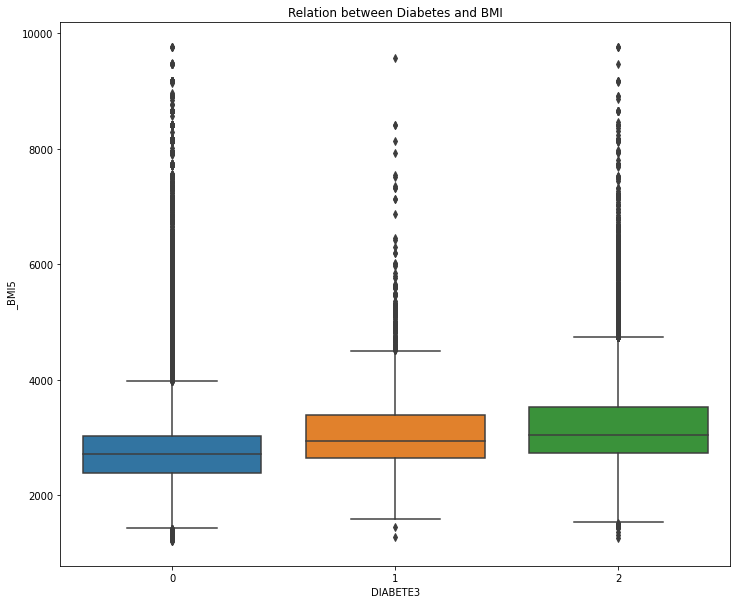

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 10))
plt.title("Relation between Diabetes and BMI")
sns.boxplot(x="DIABETE3", y="_BMI5", data=df.select(["_BMI5", "DIABETE3"]).toPandas())
plt.show()

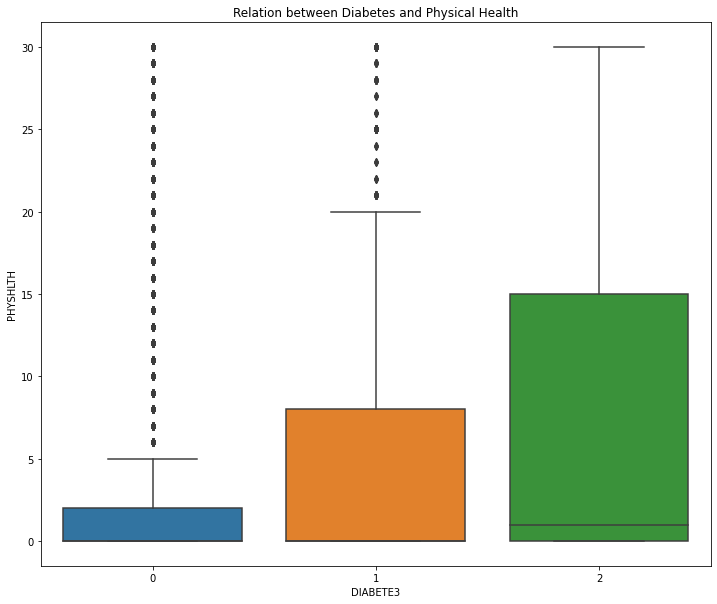

In [41]:
plt.figure(figsize=(12, 10))
plt.title("Relation between Diabetes and Physical Health")
sns.boxplot(x="DIABETE3", y="PHYSHLTH", data=df.select(["DIABETE3", "PHYSHLTH"]).toPandas())
plt.show()

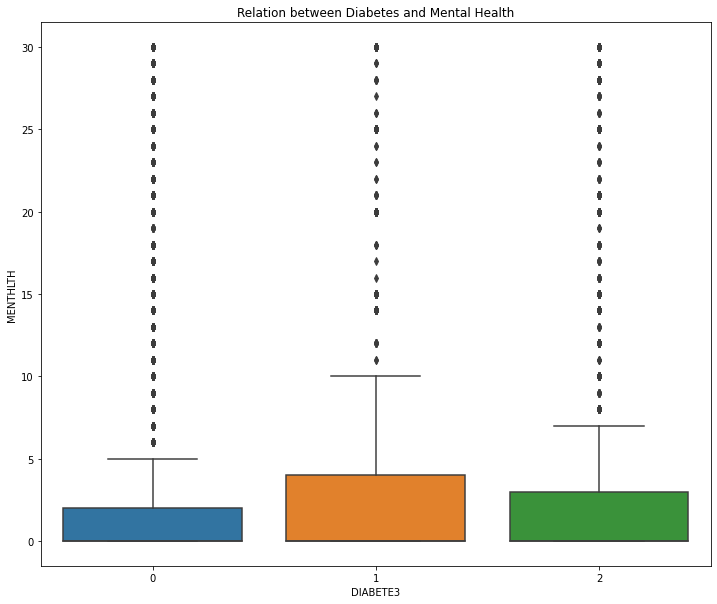

In [43]:
plt.figure(figsize=(12, 10))
plt.title("Relation between Diabetes and Mental Health")
sns.boxplot(x="DIABETE3", y="MENTHLTH", data=df.select(["DIABETE3", "MENTHLTH"]).toPandas())
plt.show()